## SVR

* Support Vector Regression (SVR) is a type of Support Vector Machine (SVM) that is adapted for regression tasks. 
* Unlike traditional regression models that minimize the error between the predicted and actual values, SVR aims to fit the best line within a threshold value, called epsilon, where the error is considered acceptable. SVR works by finding a hyperplane in a high-dimensional space that best separates the data points, but unlike SVM for classification, it seeks to keep the data points as close to this hyperplane as possible while allowing some margin of error, controlled by the epsilon parameter. 
* This approach helps to maintain a balance between model complexity and prediction accuracy, making SVR particularly effective in handling non-linear relationships through the use of kernel functions like polynomial or radial basis functions. 
* The goal of SVR is to ensure that errors do not exceed a certain threshold, while simultaneously maximizing the margin around the hyperplane, thus providing a robust predictive model.


In [90]:
import pandas as pd 

df_not_scaled = pd.read_csv('../data/not_scaled_data.csv')

In [5]:
from sklearn import metrics
import numpy as np

def calc_median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y_pred, y_test):
    r2 = metrics.r2_score(y_test, y_pred)
    smse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mean_ae = metrics.mean_absolute_error(y_test, y_pred)
    mean_ape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    median_ae = metrics.median_absolute_error(y_test, y_pred)
    median_ape = calc_median_absolute_percentage_error(y_test, y_pred)
    return [r2, smse, mean_ae, mean_ape, median_ae, median_ape]
    
def within_x_percent(y_pred, y_test, x):
    return np.sum(np.abs((y_pred - y_test)/y_test) < x) / len(y_test) * 100

def show_metrics(y_pred, y_test, target_scaler = None, logarithm = False):        
    metrics_df = pd.DataFrame(columns=['Target', 'R2', 'Root Mean Squared Error', 'Mean Absolute Error',
                                            'Mean Absolute Percentage Error', 'Median Absolute Error', 'Median Absolute Percentage Error'])
    
    metrics_df.loc[0] = ['Target as it is'] + calculate_metrics(y_pred, y_test)
    
    if target_scaler:
        y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        metrics_df.loc[1] = ['Scaled Target is inversed to real value'] + calculate_metrics(y_pred, y_test)

    
    if logarithm:
        y_pred = np.power(10, y_pred)
        y_test = np.power(10, y_test)
        metrics_df.loc[2] = ['Target -> 10 ^ Target'] + calculate_metrics(y_pred, y_test)
    
    dist_df = pd.DataFrame({"within 5%": [within_x_percent(y_pred, y_test, 0.05)],
                    "within 10%": [within_x_percent(y_pred, y_test, 0.10)],
                    "within 20%": [within_x_percent(y_pred, y_test, 0.20)],
                    "within 50%": [within_x_percent(y_pred, y_test, 0.50)],
                    "median absolute percentage error": [calc_median_absolute_percentage_error(y_test, y_pred)]}, index=['Percentage'])
        
    display(metrics_df)
    display(dist_df)

In [9]:
from abc import ABC, abstractmethod
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

class RegressionModel(ABC):
    def __init__(self, features, target, params, scale=True, logarithm=False):
        if scale:
            self.feature_scaler = StandardScaler()
            self.target_scaler = StandardScaler()
            self.features = self.feature_scaler.fit_transform(features)
            self.target = self.target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()
        else:
            self.feature_scaler = None
            self.target_scaler = None
            self.features = features
            self.target = target.values.flatten()
            
        self.logarithm = logarithm
        
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.target, test_size=0.1, random_state=42)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        self.model = self.create_model(params)
        self.search_params = self.set_search_params()
        self.model.fit(X_train, y_train)
        self.y_pred = self.model.predict(X_test)
        #show_metrics(self.model.predict(X_train), y_train, self.target_scaler, logarithm)
        
    @abstractmethod
    def create_model(self, params):
        pass
    
    @abstractmethod
    def set_search_params(self):
        pass
    
    def predict(self, features):
        if self.feature_scaler:
           features = self.feature_scaler.transform(features)
        return self.model.predict(features)
    
    def grid_search(self):
        grid_search = GridSearchCV(self.model, self.search_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=2)
        grid_search.fit(self.X_train, self.y_train)
        best_model = grid_search.best_estimator_
        test_score = best_model.score(self.X_test, self.y_test)
        self.model = best_model
        self.y_pred = self.model.predict(self.X_test)
        return best_model, test_score
    
    def show_metrics(self):
        show_metrics(self.y_pred, self.y_test, self.target_scaler, self.logarithm)
    
    def draw_predictions(self, log=False):
        if self.target_scaler:
            y_pred = self.target_scaler.inverse_transform(self.y_pred.reshape(-1, 1)).ravel()
            y_test = self.target_scaler.inverse_transform(self.y_test.reshape(-1, 1)).ravel()
        else:
            y_pred = self.y_pred
            y_test = self.y_test
        
        if log:
            y_pred = np.power(10, y_pred)
            y_test = np.power(10, y_test)
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Predicted vs Actual')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
        plt.title('Actual vs Predicted Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.show()
        
    def get_feature_importance(self):
        perm_importance = permutation_importance(self.model, self.X_train, self.y_train, n_repeats=10, random_state=42)
        feature_importances_df = pd.DataFrame({
                'Feature': self.features.columns,
                'Importance': perm_importance.importances_mean
            })
        display(feature_importances_df.sort_values(by='Importance', ascending=False))
    
                        

We first define our model. The hyperparameters that we will tune are:
* **C**: Regularization parameter. The strength of the regularization is inversely proportional to C.
* **epsilon**: The epsilon in the epsilon-SVR model. It specifies the epsilon-tube within which no penalty is associated in the training loss function with points predicted within a distance epsilon from the actual value.
* **gamma**: Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. Higher the value of gamma, will try to exact fit the as per training data set i.e. generalization error and cause over-fitting problem.
* **kernel**: Specifies the kernel type to be used in the algorithm. The kernel is used to map the input data into a higher dimensional space.(We don't include this in grid search as other kernels than rbf give poor results)

In [155]:
from sklearn.svm import SVR
class SVRModel(RegressionModel):
    def create_model(self, params):
        return SVR(**params)
    def set_search_params(self):
        return {
            'C': [0.1, 1, 10],
            'epsilon': [0.01, 0.1, 0.2, 0.5, 1],
            'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        }

### Hyperparameters

We test different values for the hyperparameters and plot the results to find the best hyperparameters.

In [182]:
def plot_mae_for_different_epsilons(features):
    epsilons = [0.01, 0.1, 0.2, 0.5, 1]
    mae = []
    for epsilon in epsilons:
        model = SVRModel(features, df_not_scaled['price'], {'C': 10, 'epsilon': epsilon, 'gamma': 'scale'})
        mae.append(metrics.mean_absolute_error(model.y_test, model.y_pred))
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=epsilons, y=mae)
    plt.title('Mean Absolute Error for different Epsilons')
    plt.xlabel('Epsilon')
    plt.ylabel('Mean Absolute Error')
    plt.show()

def plot_mae_for_different_cs(features):
    cs = [0.1, 1, 5, 10, 20]
    mae = []
    for c in cs:
        model = SVRModel(features, df_not_scaled['price'], {'C': c, 'epsilon': 0.1, 'gamma': 'scale'})
        mae.append(metrics.mean_absolute_error(model.y_test, model.y_pred))
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=cs, y=mae)
    plt.title('Mean Absolute Error for different Cs')
    plt.xlabel('C')
    plt.ylabel('Mean Absolute Error')
    plt.show()

As you can see the best value for epsilon is 0.1, for C is 5.

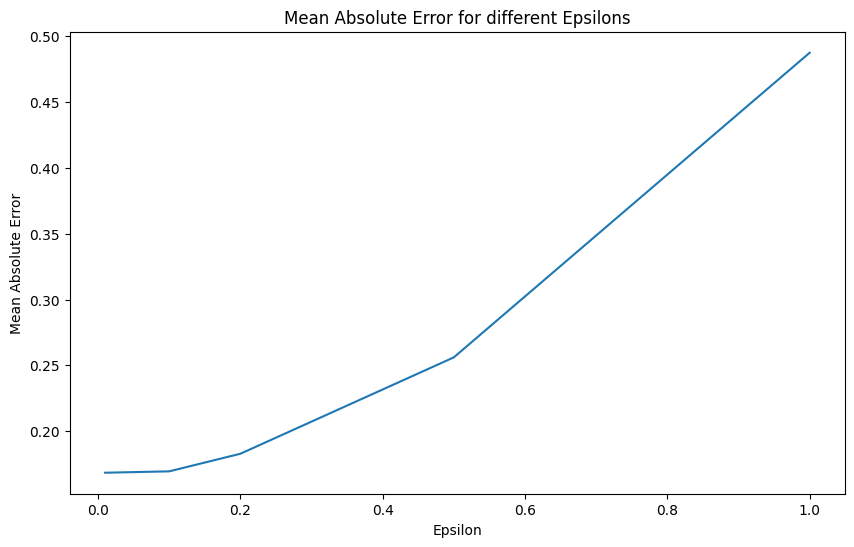

In [183]:
plot_mae_for_different_epsilons(df_not_scaled.drop(columns=['price', 'log_price']))

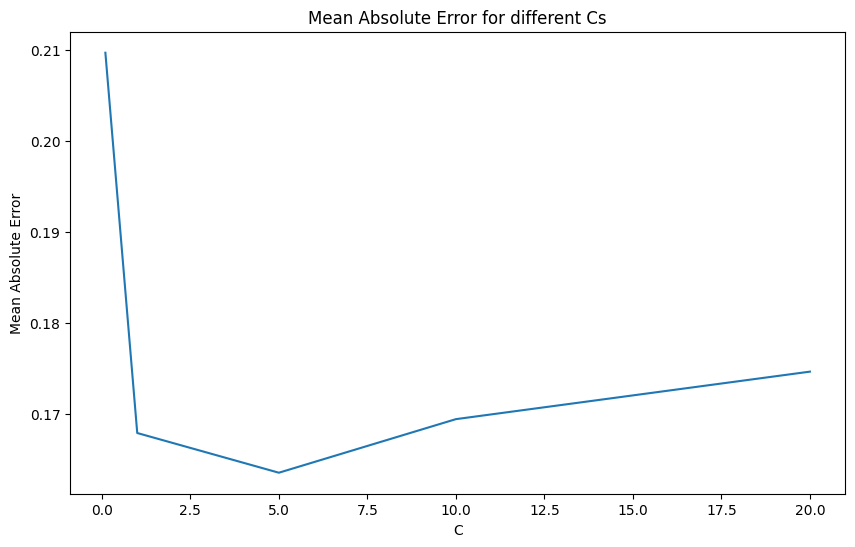

In [178]:
plot_mae_for_different_cs(df_not_scaled.drop(columns=['price', 'log_price']))

We have to note that for each set of features the best hyperparameters can change as you will see in the next cells.

### Target = log(price)

We tested the model with different features and the best results were obtained with the following features that is in the code below.
We also tested the model with different hyperparameters and the best results were obtained with the following hyperparameters:
* C = 10
* epsilon = 0.1
* gamma = auto
* kernel = rbf

As you can see we get a MAPE of 10% which is a good result compared to the other models. The reason is that SVR is a powerful model that can handle non-linear relationships through the use of kernel functions like rbf.

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target as it is,0.884116,0.356797,0.246053,1.568716,0.168844,27.197996
1,Scaled Target is inversed to real value,0.884116,0.097641,0.067335,0.011163,0.046206,0.764856
2,Target -> 10 ^ Target,0.863468,480871.293992,228013.032577,0.160460,112166.390313,10.333035


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,25.316456,48.312236,74.472574,95.56962,10.333035


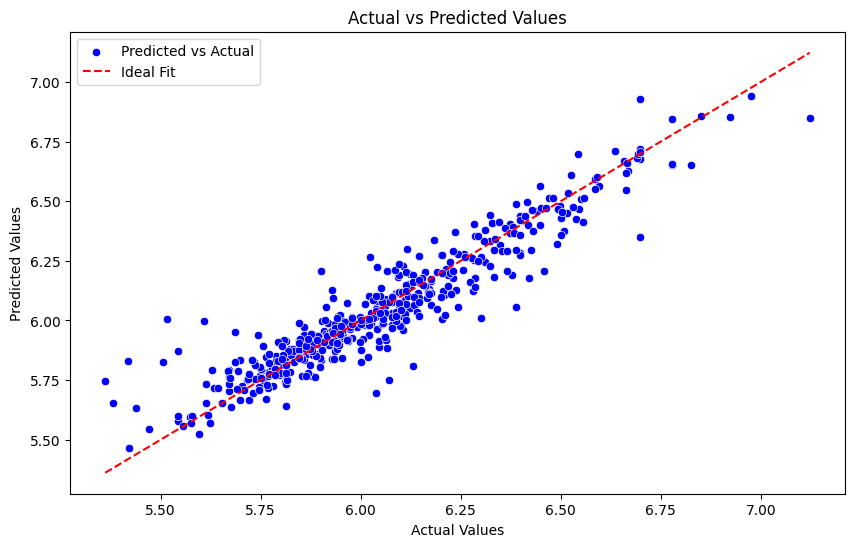

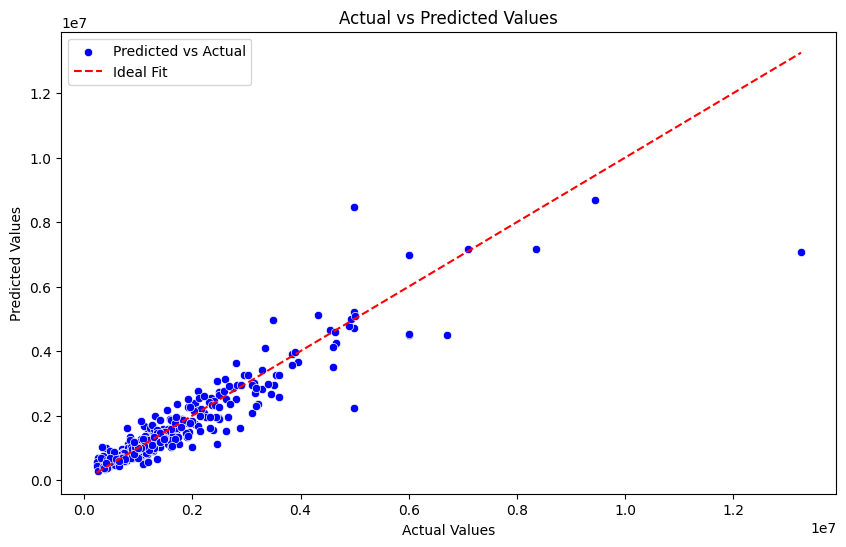

In [180]:
features = df_not_scaled[["log_taxAssessedValue", "log_livingAreaValue", "log_lotAreaValue", "hasFireplace", "rentZestimate", 
                          "bedrooms", "bathrooms", "livingAreaValue", "parkingCapacity", 'zipcode', 'hasView',
                          'hasCooling']]
target = df_not_scaled['log_price']
model = SVRModel(features, target, params={'C': 10, 'epsilon': 0.01, 'kernel': 'rbf', 'gamma': 'auto'}, scale=True, logarithm=True)
model.show_metrics()
model.draw_predictions()
model.draw_predictions(log=True)

### Target = price

We set the target to price and we tested the model with different features and the best results were obtained with the following features that is in the code below.
We also tested the model with different hyperparameters and the best results were obtained with the following hyperparameters:

* C = 10
* epsilon = 0.1
* gamma = scale
* kernel = rbf

As you can see we get a lower MAPE than the model with target = log(price) which is a good result. 

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target as it is,0.914078,0.268837,0.156629,0.854157,0.078791,18.105872
1,Scaled Target is inversed to real value,0.914078,381472.848382,222252.566108,0.160643,111802.016933,10.111872


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,24.894515,49.156118,72.995781,97.046414,10.111872


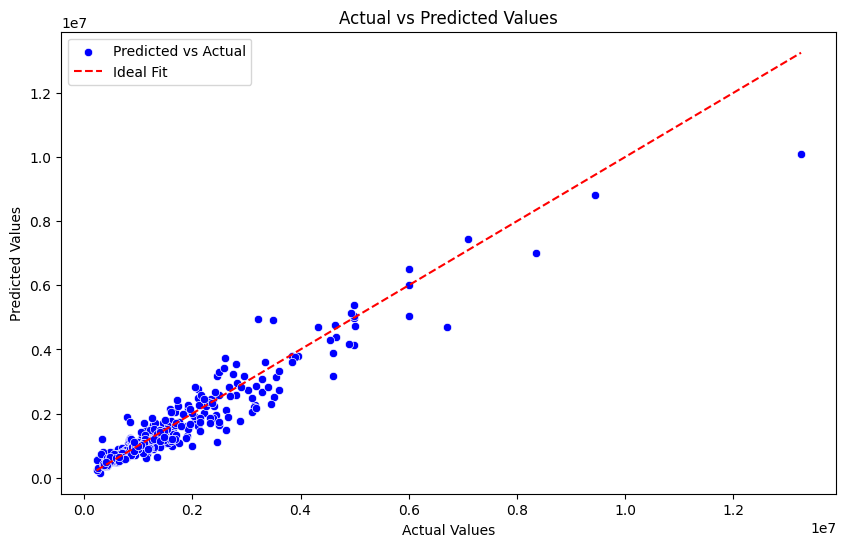

In [135]:
features = df_not_scaled[["log_livingAreaValue", "log_lotAreaValue", "rentZestimate",
                          "bedrooms", "bathrooms", "lotAreaValue", "livingAreaValue", "parkingCapacity", 'taxAssessedValue', 'hasCooling']]

target = df_not_scaled['price']
model = SVRModel(features, target, params={'C': 10, 'epsilon': 0.01, 'kernel': 'rbf', 'gamma': 'scale'}, scale=True, logarithm=False)
model.show_metrics()
model.draw_predictions()

### Model on more Filtered Data

We repeat the same process but with more filtered data. We delete the outliers in `price` column.

In [152]:
df_filtered = df_not_scaled[df_not_scaled['price'] < 2e6]
df_filtered.shape

(3946, 23)

We can see the model when the target is `log(price)` has a better MAPE for the filtered data than the unfiltered data.

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target as it is,0.719861,0.545849,0.370197,1.921854,0.233612,37.125833
1,Scaled Target is inversed to real value,0.719861,0.100626,0.068245,0.011556,0.043066,0.732836
2,Target -> 10 ^ Target,0.715120,214415.747948,143698.210898,0.163666,91481.562907,10.149170


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,30.379747,49.620253,74.177215,94.683544,10.14917


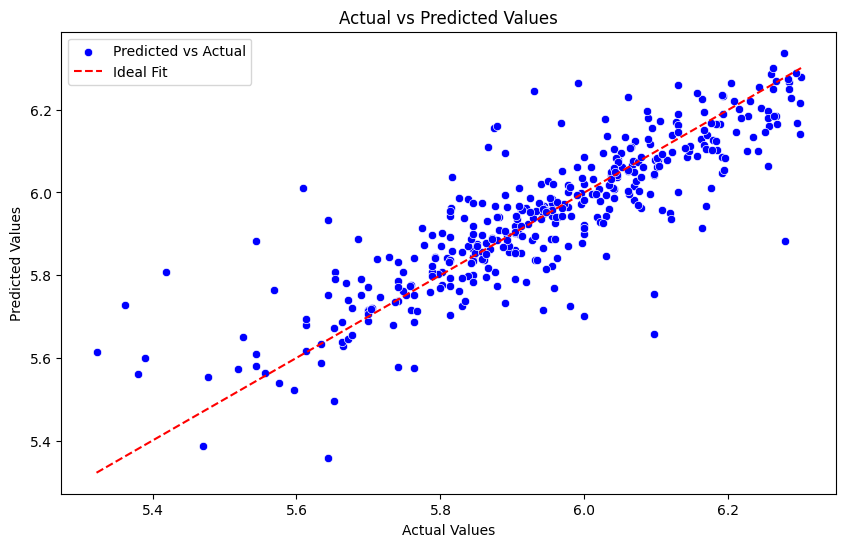

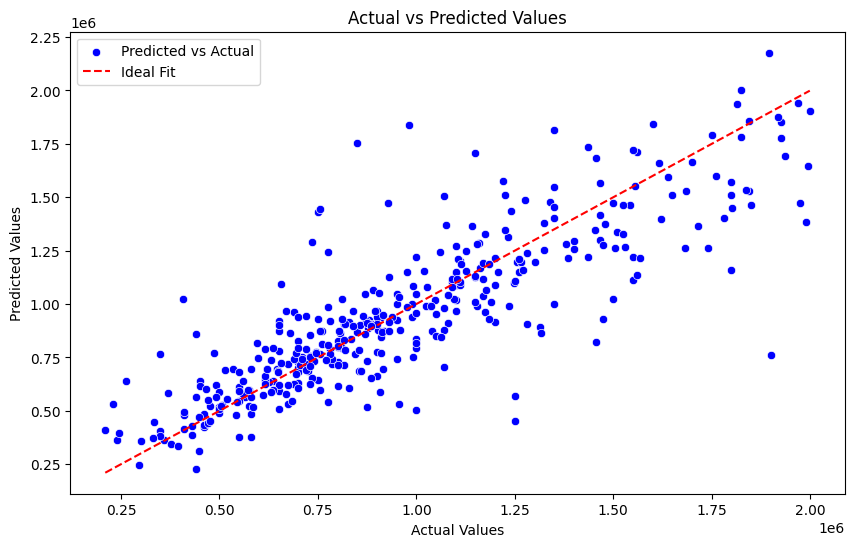

In [154]:
features = df_filtered[["log_taxAssessedValue", "log_livingAreaValue", "log_lotAreaValue", "hasFireplace", "rentZestimate", 
                          "bedrooms", "bathrooms", "livingAreaValue", "parkingCapacity", 'zipcode', 'hasView',
                          'hasCooling', 'taxAssessedValue']]
target = df_filtered['log_price']
model = SVRModel(features, target, params={'C': 10, 'epsilon': 0.01, 'kernel': 'rbf', 'gamma':'auto'}, scale=True, logarithm=True)
model.show_metrics()
model.draw_predictions()
model.draw_predictions(log=True)

You can see that in this model we get a MAPE is less than 10% and median absolute error is 88000. This is a good result and we can say that the model is acceptable for normal houses(houses that are not too expensive).

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target as it is,0.752576,0.510953,0.356119,2.047441,0.225176,32.619630
1,Scaled Target is inversed to real value,0.752576,199823.532571,139271.302871,0.159054,88061.751940,9.948658


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,27.088608,50.379747,72.658228,95.696203,9.948658


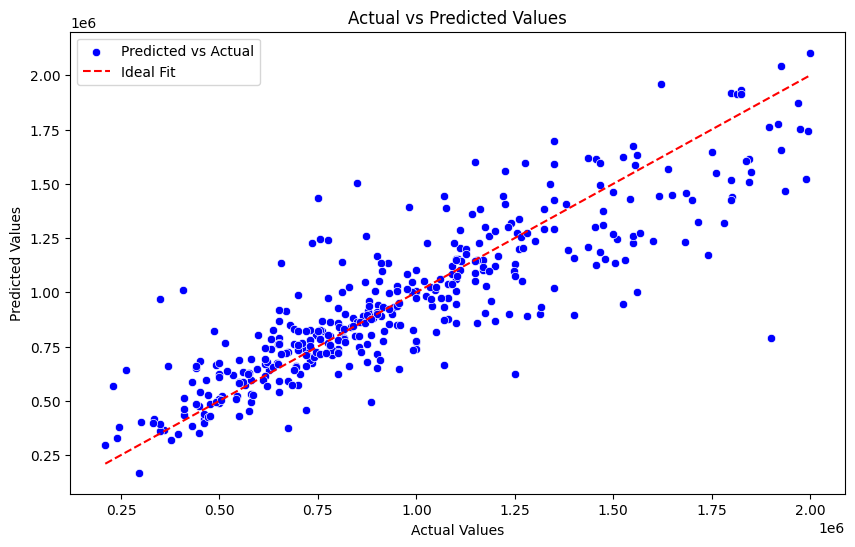

In [150]:
features = df_filtered[["log_livingAreaValue", "log_lotAreaValue", "rentZestimate",
                          "bedrooms", "bathrooms", "lotAreaValue", "livingAreaValue", "parkingCapacity", 'taxAssessedValue', 'hasHeating']]

target = df_filtered['price']
model = SVRModel(features, target, params={'C': 10, 'epsilon': 0.01, 'kernel': 'rbf', 'gamma': 'auto'}, scale=True, logarithm=False)
model.show_metrics()
model.draw_predictions()